In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import svm,metrics,preprocessing
import os

2024-03-09 07:56:08.182481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 07:56:08.182576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 07:56:08.316798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE=224
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [3]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

In [4]:
PATH="/kaggle/input/efficientnet-weights-on-vgg/enet_b0_8_best_afew.pt"

In [5]:
feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()
feature_extractor_model=feature_extractor_model.to(device)

In [6]:
emotion_to_index={
    "Neutral":0,
    "Positive":1,
    "Negative":2
}

In [7]:
def features(data_dir):
    x=[]
    y=[]
    cnt=0
    mx=-1
    for emotion in os.listdir(data_dir):
        file_path=os.path.join(data_dir,emotion)
        for filename in os.listdir(file_path):
            cnt+=1
            if cnt%500 == 0:
                print(cnt,mx)
            image_path=os.path.join(file_path,filename)
            faces=[]
            weights=[]
            mx=max(mx,len(os.listdir(image_path)))
            X_face_features=[]
            for face_name in os.listdir(image_path):
                face_path=os.path.join(image_path,face_name)
                face_img = Image.open(face_path)
                face_img_tensor = test_transforms(face_img)
                faces.append(face_img_tensor)
                if len(faces)%32 == 0:
                    scores = feature_extractor_model(torch.stack(faces, dim=0).to(device))
                    scores=scores.data.cpu().numpy() # scores.shape=(number of faces,1280 features)
                    if len(X_face_features) == 0:
                        X_face_features = scores
                    else:
                        X_face_features= np.concatenate((X_face_features,scores),axis=0)
                    faces=[]
                
            if not len(faces) == 0:
                scores = feature_extractor_model(torch.stack(faces, dim=0).to(device))
                scores=scores.data.cpu().numpy() # scores.shape=(number of faces,1280 features)
                if len(X_face_features) == 0:
                    X_face_features = scores
                else:
                    X_face_features= np.concatenate((X_face_features,scores),axis=0)
                faces=[]
                
            mean_features = (np.mean(X_face_features, axis=0))
            std_features = (np.std(X_face_features, axis=0))
            max_features = (np.max(X_face_features, axis=0))
            min_features = (np.min(X_face_features, axis=0))

            Net_feature = np.concatenate((mean_features, std_features), axis=None)
            x.append(Net_feature)
            y.append(emotion_to_index[emotion])
            
    x=np.array(x)
    y=np.array(y)
    print(x.shape,y.shape)
    return x,y

In [8]:
from sklearn.metrics import classification_report
def confusion_matrix(y_pred,y_val):
    yhat_valid = y_pred
    val_labels_onehot = tf.keras.utils.to_categorical(y_val)
    print(f'total wrong validation predictions: {np.sum(np.argmax(val_labels_onehot, axis=1) != yhat_valid)}\n\n')
    print(classification_report(np.argmax(val_labels_onehot, axis=1), yhat_valid))

In [9]:
import seaborn as sns
from matplotlib import pyplot

def draw_graph(history):
    sns.set()
    fig = plt.figure(figsize=(12, 4))

    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()

# **Non-aligned**

In [10]:
DATA_DIR='/kaggle/input/gaf-extracted-faces/GAF_extracted_faces/GAF_faces'

In [11]:
x_train,y_train=features(os.path.join(DATA_DIR,"Train"))

500 165
1000 165
1500 168
2000 217
2500 217
3000 219
3500 219
4000 219
4500 219
5000 219
5500 219
6000 219
6500 219
7000 219
7500 219
8000 219
8500 219
9000 219
9500 219
(9791, 2560) (9791,)


In [12]:
x_val,y_val=features(os.path.join(DATA_DIR,"Validation"))


500 106
1000 117
1500 117
2000 117
2500 140
3000 140
3500 172
4000 172
(4328, 2560) (4328,)


In [13]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_val,norm='l2')

In [14]:
clf = svm.SVC(kernel='rbf',C=1.9)
if True:    
    clf.fit(x_train_norm, y_train)
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
print("Complete accuracy:",metrics.accuracy_score(y_val, y_pred))

Complete accuracy: 0.7488447319778189


In [15]:
print("Overall Confusion matrix:\n")
confusion_matrix(y_pred, y_val)

Overall Confusion matrix:

total wrong validation predictions: 1087


              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1359
           1       0.86      0.86      0.86      1746
           2       0.70      0.65      0.67      1223

    accuracy                           0.75      4328
   macro avg       0.74      0.74      0.74      4328
weighted avg       0.75      0.75      0.75      4328



In [16]:
model = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
print(model)

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train_norm, y_train, epochs=50, batch_size=32, validation_data=(x_test_norm, y_val))

Epoch 1/50


I0000 00:00:1709972104.044239     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


306/306 [==============================] - 4s 5ms/step - loss: 0.6848 - accuracy: 0.6777 - val_loss: 0.6524 - val_accuracy: 0.7211
Epoch 2/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5969 - accuracy: 0.7321 - val_loss: 0.6424 - val_accuracy: 0.7234
Epoch 3/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5712 - accuracy: 0.7424 - val_loss: 0.5991 - val_accuracy: 0.7357
Epoch 4/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5441 - accuracy: 0.7650 - val_loss: 0.5907 - val_accuracy: 0.7445
Epoch 5/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5272 - accuracy: 0.7715 - val_loss: 0.5983 - val_accuracy: 0.7382
Epoch 6/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5103 - accuracy: 0.7764 - val_loss: 0.6198 - val_accuracy: 0.7421
Epoch 7/50
306/306 [==============================] - 1s 4ms/step - loss: 0.4896 - accuracy: 0.7868 - val_loss: 0.6741 - val_accuracy: 0.7232
Epoch 8/50
306/30

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

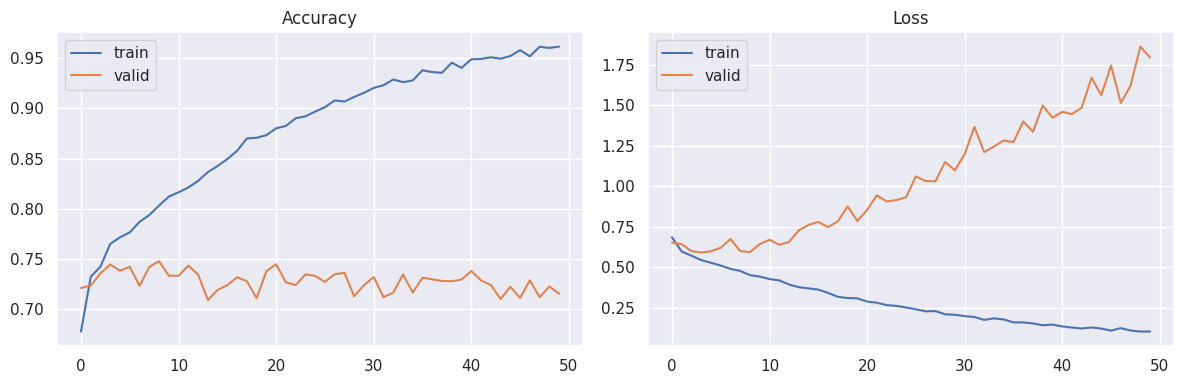

In [18]:
draw_graph(history)

In [19]:
print("Overall Confusion matrix:\n")
confusion_matrix(y_pred, y_val)

Overall Confusion matrix:

total wrong validation predictions: 1087


              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1359
           1       0.86      0.86      0.86      1746
           2       0.70      0.65      0.67      1223

    accuracy                           0.75      4328
   macro avg       0.74      0.74      0.74      4328
weighted avg       0.75      0.75      0.75      4328



# Aligned

In [20]:
DATA_DIR_ALIGN='/kaggle/input/gaf-extracted-faces/GAF_faces_aligned/GAF_faces_aligned'

In [21]:
x_train,y_train=features(os.path.join(DATA_DIR_ALIGN,"Train"))

500 165
1000 165
1500 168
2000 217
2500 217
3000 219
3500 219
4000 219
4500 219
5000 219
5500 219
6000 219
6500 219
7000 219
7500 219
8000 219
8500 219
9000 219
9500 219
(9791, 2560) (9791,)


In [22]:
x_val,y_val=features(os.path.join(DATA_DIR,"Validation"))

500 106
1000 117
1500 117
2000 117
2500 140
3000 140
3500 172
4000 172
(4328, 2560) (4328,)


In [23]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_val,norm='l2')

In [24]:
clf = svm.SVC(kernel='rbf',C=1.9)
if True:    
    clf.fit(x_train_norm, y_train)
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
print("Complete accuracy:",metrics.accuracy_score(y_val, y_pred))

Complete accuracy: 0.7474584103512015


In [25]:
print("Overall Confusion matrix:\n")
confusion_matrix(y_pred, y_val)

Overall Confusion matrix:

total wrong validation predictions: 1093


              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1359
           1       0.83      0.87      0.85      1746
           2       0.72      0.62      0.66      1223

    accuracy                           0.75      4328
   macro avg       0.74      0.73      0.73      4328
weighted avg       0.75      0.75      0.75      4328



In [26]:
model = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
print(model)

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train_norm, y_train, epochs=50, batch_size=32, validation_data=(x_test_norm, y_val))

Epoch 1/50
306/306 [==============================] - 2s 4ms/step - loss: 0.6790 - accuracy: 0.6825 - val_loss: 0.6894 - val_accuracy: 0.6878
Epoch 2/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5920 - accuracy: 0.7333 - val_loss: 0.6334 - val_accuracy: 0.7274
Epoch 3/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5657 - accuracy: 0.7470 - val_loss: 0.6270 - val_accuracy: 0.7304
Epoch 4/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5415 - accuracy: 0.7595 - val_loss: 0.6122 - val_accuracy: 0.7368
Epoch 5/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5268 - accuracy: 0.7650 - val_loss: 0.5904 - val_accuracy: 0.7440
Epoch 6/50
306/306 [==============================] - 1s 4ms/step - loss: 0.5071 - accuracy: 0.7758 - val_loss: 0.6142 - val_accuracy: 0.7396
Epoch 7/50
306/306 [==============================] - 1s 4ms/step - loss: 0.4940 - accuracy: 0.7832 - val_loss: 0.6567 - val_accuracy: 0.7211
Epoch 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

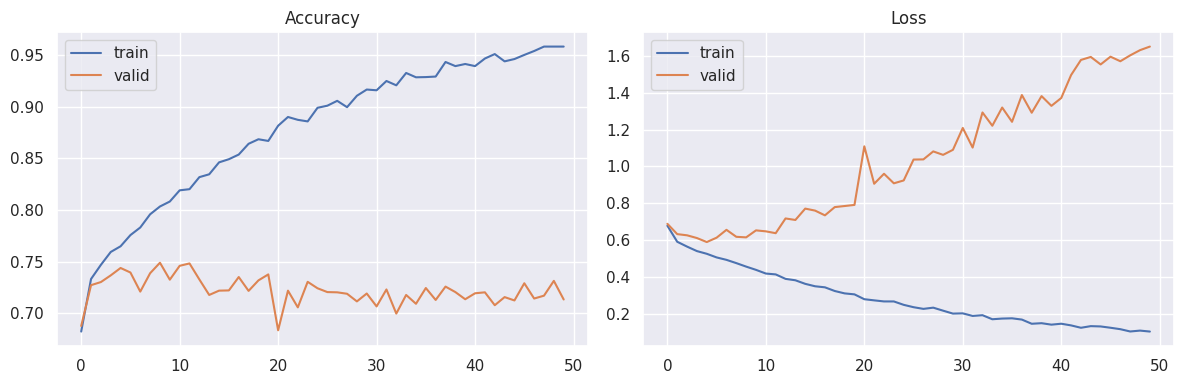

In [28]:
draw_graph(history)

In [29]:
print("Overall Confusion matrix:\n")
confusion_matrix(y_pred, y_val)

Overall Confusion matrix:

total wrong validation predictions: 1093


              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1359
           1       0.83      0.87      0.85      1746
           2       0.72      0.62      0.66      1223

    accuracy                           0.75      4328
   macro avg       0.74      0.73      0.73      4328
weighted avg       0.75      0.75      0.75      4328

